# Customer Churn Prediction
## Exploration notebook - WIP

TODO: clean this up later

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load customer data
# (run `python generate_sample_data.py` first if the file doesn't exist)
df = pd.read_csv('../data/customer_data.csv')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (5000, 10)


,customer_id,recency_days,frequency,monetary_value,avg_order_value,days_since_signup,total_orders,support_tickets,age,churned
0,1,156,9,6800.38,759.81,596,9,0,18,1
1,2,66,14,792.94,94.69,393,7,0,29,0
2,3,97,3,1005.08,285.39,367,3,0,37,1
3,4,1,11,2844.91,404.44,367,6,0,38,0
4,5,19,5,1749.75,136.75,1084,12,2,18,1


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        5000 non-null   int64  
 1   recency_days       5000 non-null   int64  
 2   frequency          5000 non-null   int64  
 3   monetary_value     5000 non-null   float64
 4   avg_order_value    5000 non-null   float64
 5   days_since_signup  5000 non-null   int64  
 6   total_orders       5000 non-null   int64  
 7   support_tickets    5000 non-null   int64  
 8   age                5000 non-null   int64  
 9   churned            5000 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 390.8 KB


In [4]:
df.describe()

,customer_id,recency_days,frequency,monetary_value,avg_order_value,days_since_signup,total_orders,support_tickets,age,churned
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,69.058800,10.728400,1573.179302,244.907142,500.76300,7.562400,0.972200,39.995400,0.490400
std,1443.520003,67.941087,5.180811,1240.720473,227.646047,304.74602,5.894731,1.329128,13.784679,0.499958
min,1.000000,0.000000,0.000000,50.000000,10.000000,30.00000,1.000000,0.000000,18.000000,0.000000
25%,1250.750000,19.000000,7.000000,707.985000,94.705000,274.00000,3.000000,0.000000,30.000000,0.000000
50%,2500.500000,48.000000,10.000000,1272.055000,174.840000,438.00000,6.000000,1.000000,40.000000,0.000000
75%,3750.250000,98.000000,14.000000,2077.460000,315.130000,664.25000,10.000000,1.000000,49.000000,1.000000
max,5000.000000,365.000000,31.000000,11958.630000,3034.510000,1500.00000,44.000000,11.000000,75.000000,1.000000


In [5]:
# check target distribution
df['churned'].value_counts()

churned
0    2548
1    2452
Name: count, dtype: int64

In [6]:
df['churned'].value_counts(normalize=True)

churned
0    0.5096
1    0.4904
Name: proportion, dtype: float64

In [7]:
# check for missing values
df.isnull().sum()

customer_id          0
recency_days         0
frequency            0
monetary_value       0
avg_order_value      0
days_since_signup    0
total_orders         0
support_tickets      0
age                  0
churned              0
dtype: int64

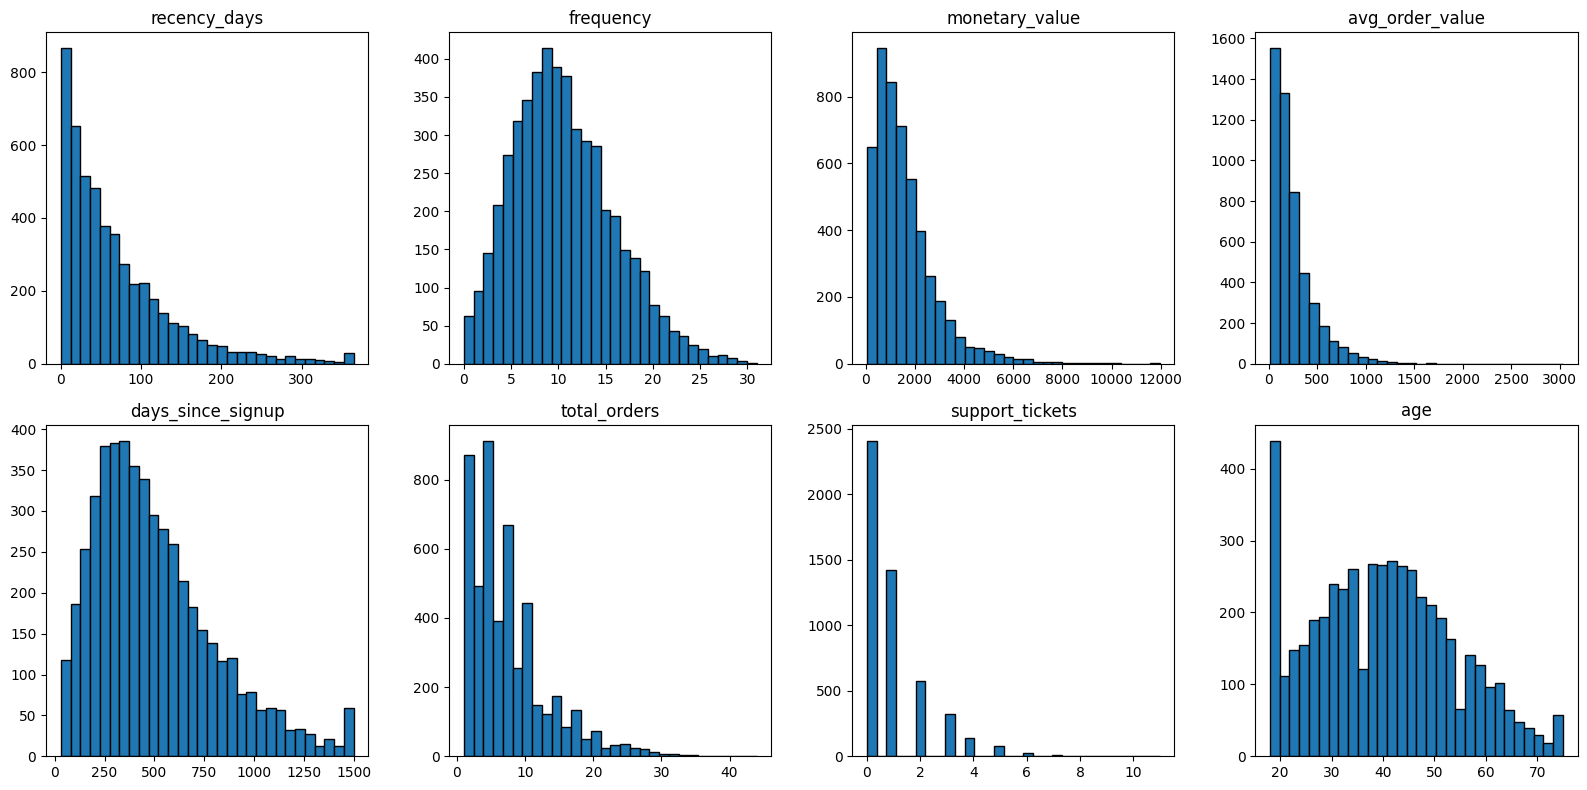

In [8]:
# distribution plots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df.columns[1:-1]):  # skip customer_id and churned
    axes[i].hist(df[col], bins=30, edgecolor='black')
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

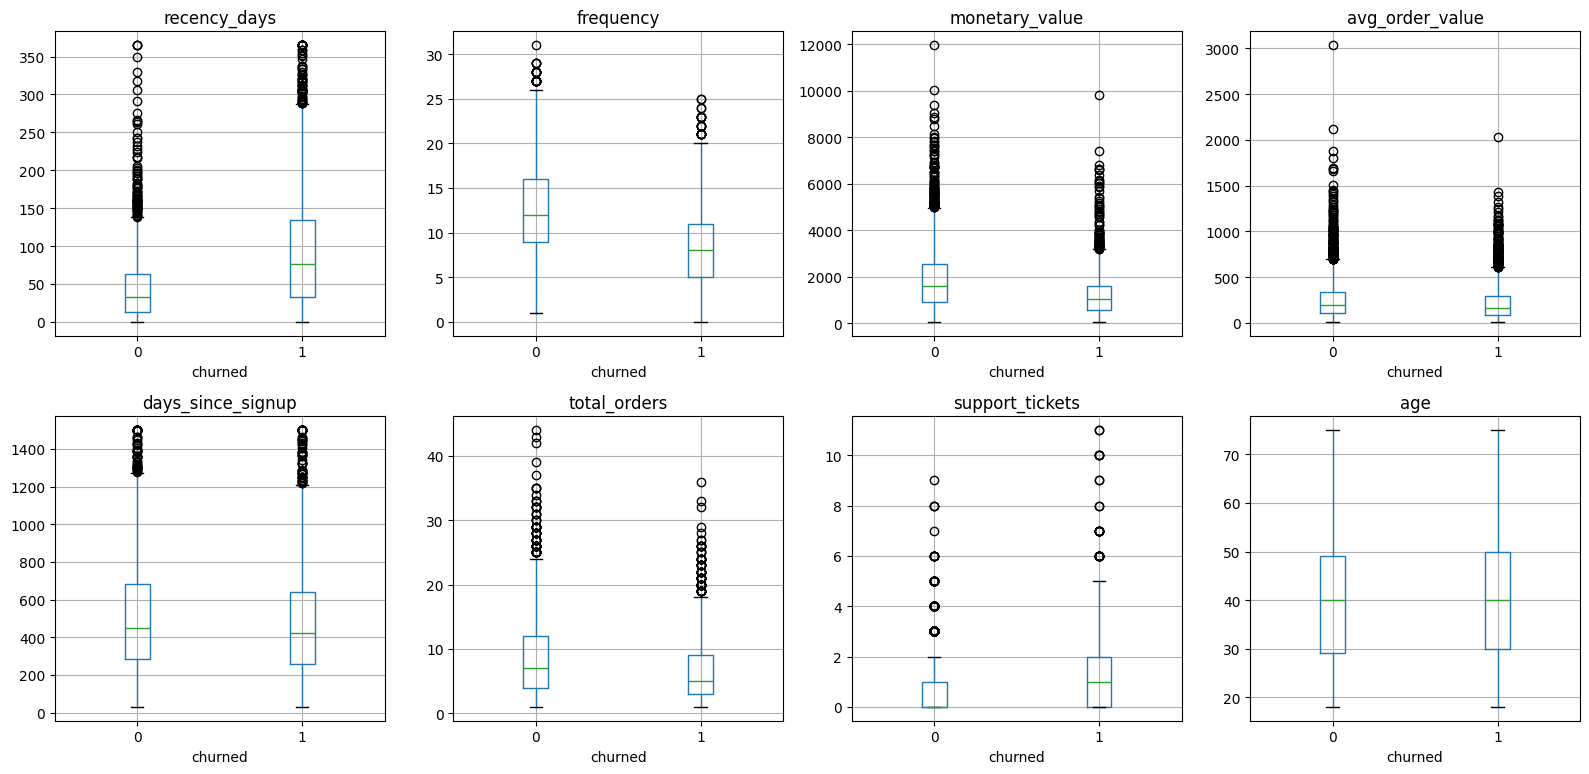

In [9]:
# boxplots by churn status
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df.columns[1:-1]):
    df.boxplot(column=col, by='churned', ax=axes[i])
    axes[i].set_title(col)

plt.suptitle('')
plt.tight_layout()
plt.show()

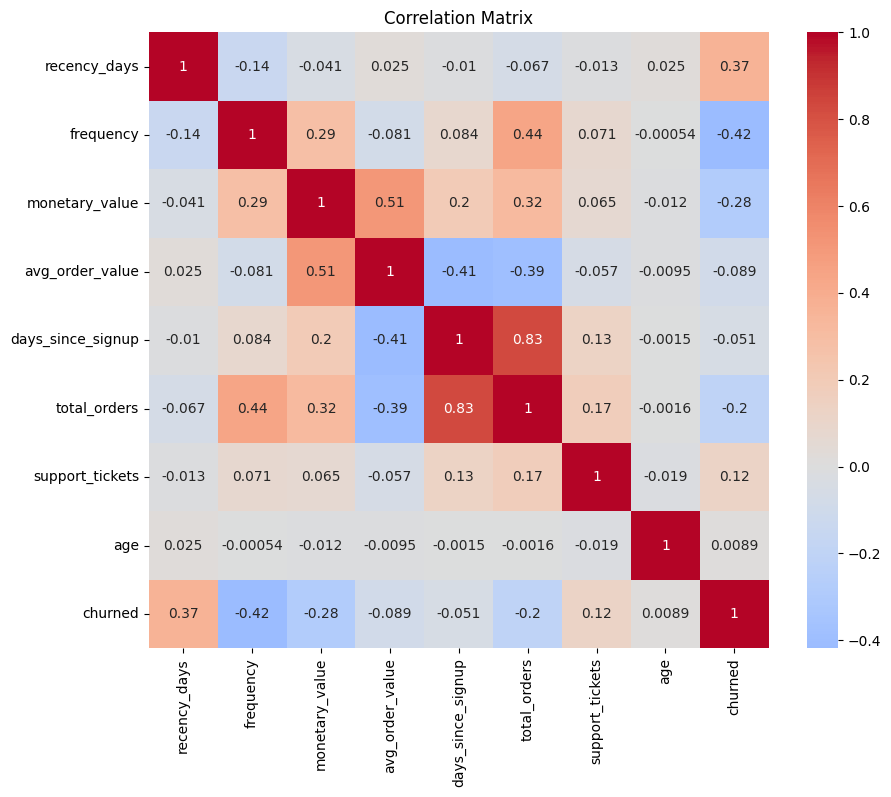

In [10]:
# correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('customer_id', axis=1).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Feature Engineering

Let's create some new features

In [11]:
# create new features
df['recency_frequency_ratio'] = df['recency_days'] / (df['frequency'] + 1)
df['monetary_per_order'] = df['monetary_value'] / (df['total_orders'] + 1)
df['order_frequency'] = df['total_orders'] / (df['days_since_signup'] + 1)
df['support_per_order'] = df['support_tickets'] / (df['total_orders'] + 1)

# RFM score - manual binning
df['r_score'] = pd.qcut(df['recency_days'], q=5, labels=[5, 4, 3, 2, 1]).astype(int)
df['f_score'] = pd.qcut(df['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)
df['m_score'] = pd.qcut(df['monetary_value'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)
df['rfm_score'] = df['r_score'] + df['f_score'] + df['m_score']

df.head()

,customer_id,recency_days,frequency,monetary_value,avg_order_value,days_since_signup,total_orders,support_tickets,age,churned,recency_frequency_ratio,monetary_per_order,order_frequency,support_per_order,r_score,f_score,m_score,rfm_score
0,1,156,9,6800.38,759.81,596,9,0,18,1,15.600000,680.038000,0.015075,0.000000,1,2,5,8
1,2,66,14,792.94,94.69,393,7,0,29,0,4.400000,99.117500,0.017766,0.000000,2,4,2,8
2,3,97,3,1005.08,285.39,367,3,0,37,1,24.250000,251.270000,0.008152,0.000000,2,1,2,5
3,4,1,11,2844.91,404.44,367,6,0,38,0,0.083333,406.415714,0.016304,0.000000,5,3,5,13
4,5,19,5,1749.75,136.75,1084,12,2,18,1,3.166667,134.596154,0.011060,0.153846,4,1,4,9


In [12]:
df.shape

(5000, 18)

## Prepare data for modeling

In [13]:
# features to use
feature_cols = [
    'recency_days', 'frequency', 'monetary_value', 'avg_order_value',
    'days_since_signup', 'total_orders', 'support_tickets', 'age',
    'recency_frequency_ratio', 'monetary_per_order', 'order_frequency',
    'support_per_order', 'rfm_score'
]

X = df[feature_cols]
y = df['churned']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (5000, 13)
Target shape: (5000,)


In [14]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 4000 samples
Test set: 1000 samples


In [15]:
# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model 1: Logistic Regression

In [16]:
# logistic regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1: {f1_score(y_test, y_pred_lr):.4f}")

Logistic Regression Results:
Accuracy: 0.8050
Precision: 0.8067
Recall: 0.7918
F1: 0.7992


In [17]:
# cross validation
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

CV Accuracy: 0.7815 (+/- 0.0137)


## Model 2: Random Forest

In [18]:
# random forest - try different params
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest (n_estimators=100) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1: {f1_score(y_test, y_pred_rf):.4f}")

Random Forest (n_estimators=100) Results:
Accuracy: 0.7770
Precision: 0.7730
Recall: 0.7714
F1: 0.7722


In [19]:
# hmm let's try more trees
rf2 = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf2.fit(X_train, y_train)

y_pred_rf2 = rf2.predict(X_test)

print("Random Forest (n_estimators=200, max_depth=10) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf2):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf2):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf2):.4f}")
print(f"F1: {f1_score(y_test, y_pred_rf2):.4f}")

Random Forest (n_estimators=200, max_depth=10) Results:
Accuracy: 0.7840
Precision: 0.7796
Recall: 0.7796
F1: 0.7796


In [20]:
# try another config
rf3 = RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_split=10, random_state=42, n_jobs=-1)
rf3.fit(X_train, y_train)

y_pred_rf3 = rf3.predict(X_test)

print("Random Forest (n_estimators=150, max_depth=15, min_samples_split=10) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf3):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf3):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf3):.4f}")
print(f"F1: {f1_score(y_test, y_pred_rf3):.4f}")

Random Forest (n_estimators=150, max_depth=15, min_samples_split=10) Results:
Accuracy: 0.7860
Precision: 0.7816
Recall: 0.7816
F1: 0.7816


In [21]:
# cross validation on best RF so far
cv_scores_rf = cross_val_score(rf2, X_train, y_train, cv=5, scoring='accuracy')
print(f"RF CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std()*2:.4f})")

RF CV Accuracy: 0.7737 (+/- 0.0104)


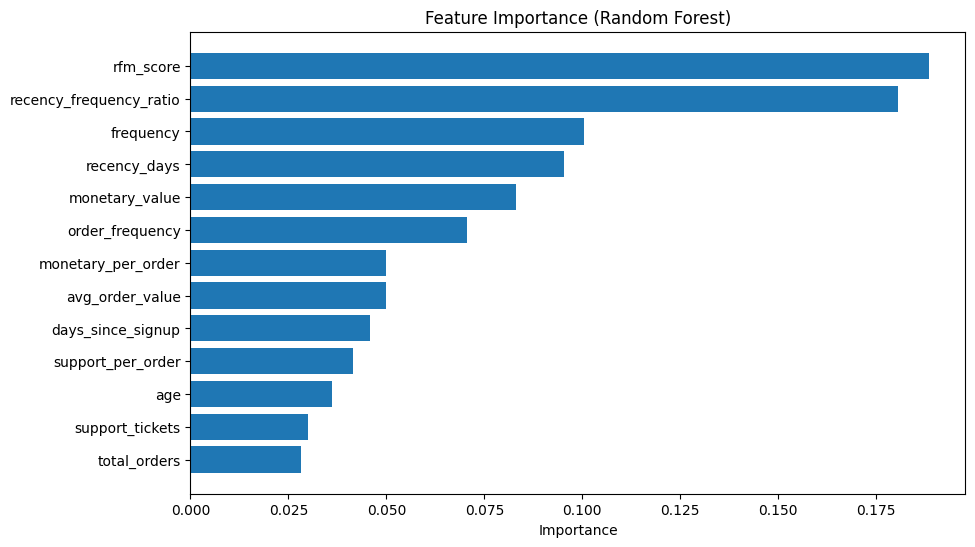

In [22]:
# feature importance
feat_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

## Model 3: Gradient Boosting

In [23]:
# gradient boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1: {f1_score(y_test, y_pred_gb):.4f}")

Gradient Boosting Results:
Accuracy: 0.7970
Precision: 0.7923
Recall: 0.7939
F1: 0.7931


In [24]:
# try different learning rate
gb2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gb2.fit(X_train, y_train)

y_pred_gb2 = gb2.predict(X_test)

print("Gradient Boosting (lr=0.05, n=200) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb2):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb2):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb2):.4f}")
print(f"F1: {f1_score(y_test, y_pred_gb2):.4f}")

Gradient Boosting (lr=0.05, n=200) Results:
Accuracy: 0.7850
Precision: 0.7847
Recall: 0.7735
F1: 0.7790


## Hyperparameter tuning with GridSearch

Let me try grid search on RF

In [25]:
# grid search - this takes a while
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.7705


In [26]:
# evaluate best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Best Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1: {f1_score(y_test, y_pred_best):.4f}")

Best Random Forest Results:
Accuracy: 0.7810
Precision: 0.7771
Recall: 0.7755
F1: 0.7763


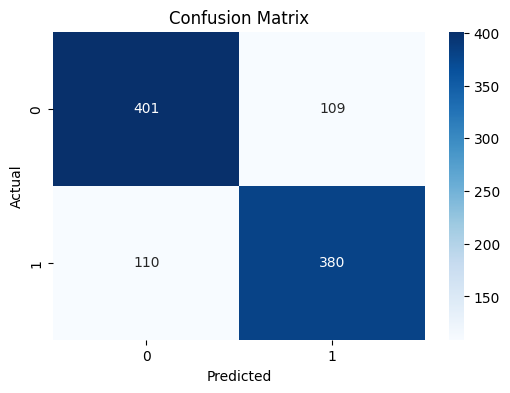

In [27]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       510
           1       0.78      0.78      0.78       490

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



## Summary

| Model | Accuracy | Precision | Recall | F1 |
|-------|----------|-----------|--------|----|
| Logistic Regression | ? | ? | ? | ? |
| Random Forest (100) | ? | ? | ? | ? |
| Random Forest (200, depth=10) | ? | ? | ? | ? |
| Gradient Boosting | ? | ? | ? | ? |
| Best RF (grid search) | ? | ? | ? | ? |

TODO: fill in the table manually...

Best model seems to be RF with grid search params. Need to save this model and deploy somehow.

In [29]:
# save model? idk where
# import pickle
# with open('model.pkl', 'wb') as f:
#     pickle.dump(best_rf, f)

# wait which model was the best again? let me scroll up...

In [30]:
# actually let me try one more thing - what if I remove some features?
# maybe I'm overfitting

# top features only
top_features = feat_imp.head(8)['feature'].tolist()
print(f"Top features: {top_features}")

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

rf_top = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_top.fit(X_train_top, y_train)

y_pred_top = rf_top.predict(X_test_top)

print("\nRF with top 8 features:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_top):.4f}")
print(f"F1: {f1_score(y_test, y_pred_top):.4f}")

Top features: ['rfm_score', 'recency_frequency_ratio', 'frequency', 'recency_days', 'monetary_value', 'order_frequency', 'monetary_per_order', 'avg_order_value']

RF with top 8 features:
Accuracy: 0.7700
F1: 0.7653


In [31]:
# ok I give up trying to track all these experiments
# which one was the best? I think it was the grid search one?
# or was it the gb2? 

# TODO: use mlflow or something to track all this...

---

## Notes to self

- Best model: probably RF from grid search?
- Need to figure out how to track experiments better
- Should I save the scaler too? 
- How do I deploy this?
- Marie said something about MLflow?
- Also need to run this daily for new customers - manually? cron job?

**Problems with this notebook:**
1. Can't remember which model was best
2. Metrics are scattered everywhere
3. No versioning of models
4. Can't reproduce exact results
5. No automation
6. Hardcoded everything